### Analiza Attention po uczeniu (dla epizodów ewaluacyjnych)

Kod poniżej uruchamia serię epizodów ewaluacyjnych modelu RL, aby zebrać statystyki związane z mechanizmem uwagi w ekstraktorze cech. Dla każdej obserwacji zapisuje wartości metric_importance, contrib_importance i macierze uwagi, po czym wylicza średnie, wariancje i częstości przekroczenia progu. 

In [1]:
# eval_attention_stats.py
import os
import time
from typing import Optional, Sequence, Dict, Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import torch as th

# ---------- drobne funkcje pomocnicze (zgodne z gym/gymnasium) ----------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _to_1d_bool(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.ndim == 0:
        return np.array([bool(x)], dtype=bool)
    if x.ndim > 1:
        x = x.reshape(-1)
    return x

# ---------- główna ewaluacja i statystyki ----------
@th.no_grad()
def evaluate_attention_stats(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    eps: float = 1e-8,                # próg dla „freq”
    top_k: int = 30,
    save_dir: Optional[str] = None,   # jeśli None: brak zapisywania plików
    save_prefix: str = "attn_eval",
    make_plots: bool = True,
) -> Dict[str, Any]:
    """
    Uruchamia epizody ewaluacyjne i oblicza te same statystyki, co callback uwagi wykorzystywany podczas treningu.

    Zwraca słownik zawierający:
      - 'metric_mean', 'metric_var', 'metric_freq'   : [N] (średnia, wariancja i częstość metryk)
      - 'contrib_mean', 'contrib_var', 'contrib_freq': [N] (średnia, wariancja i częstość wkładu cech)
      - 'A_mean'                                     : [N, N] (średnia macierz uwagi)
      - 'feature_names'                              : [N] (nazwy cech)
      - 'episodes', 'steps_total', 'ep_returns'      : metadane
      - oraz 'tables' z posortowanymi (top_k) DataFrame, jeśli dostępne jest pandas
    """
    # zachowaj semantykę nagrody VecNormalize = prawdziwa nagroda środowiska
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    fe = getattr(model.policy, "features_extractor", None)
    if fe is None or not hasattr(fe, "metric_importance"):
        raise AttributeError("Policy features_extractor missing 'metric_importance' / 'contrib_importance'.")

    # Wyznacz N oraz nazwy cech
    N = getattr(fe, "n_metrics", None) or getattr(fe, "final_out_dim", None)
    if N is None:
        # ostatnia deska ratunku z przestrzeni obserwacji
        N = int(getattr(env, "observation_space").shape[-1])
    if FEATURE_NAMES is None or len(FEATURE_NAMES) != N:
        feature_names = np.array([f"f{i}" for i in range(N)], dtype=str)
    else:
        feature_names = np.array(list(FEATURE_NAMES), dtype=str)

    metric_list: List[np.ndarray] = []
    contrib_list: List[np.ndarray] = []
    A_sum = None
    A_count = 0
    ep_returns: List[float] = []

    state = None
    steps_total = 0

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):  # gymnasium (obserwacja, info)
            obs = obs[0]

        episode_start = np.array([True], dtype=bool) if is_vec else None
        done = False
        ret = 0.0

        while not done:
            # Przewidź akcję (obsługa RecurrentPPO)
            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(
                    obs, state=state, deterministic=deterministic
                )

            # --- odczytaj diagnostykę uwagi dla bieżącej obserwacji ---
            mi = getattr(fe, "metric_importance", None)
            if mi is not None:
                mi_np = mi.detach().cpu().numpy()
                if mi_np.ndim == 2:
                    metric_list.append(mi_np[0].copy() if mi_np.shape[0] == 1 else mi_np.mean(axis=0).copy())
                elif mi_np.ndim == 1:
                    metric_list.append(mi_np.copy())

            ci = getattr(fe, "contrib_importance", None)
            if ci is not None:
                ci_np = ci.detach().cpu().numpy()
                if ci_np.ndim == 2:
                    contrib_list.append(ci_np[0].copy() if ci_np.shape[0] == 1 else ci_np.mean(axis=0).copy())
                elif ci_np.ndim == 1:
                    contrib_list.append(ci_np.copy())

            A = getattr(fe, "attn_matrix", None)
            if A is not None:
                A_np = A.detach().cpu().numpy()
                if A_np.ndim == 3:
                    A_np = A_np[0]
                if A_sum is None:
                    A_sum = A_np.astype(np.float64)
                else:
                    A_sum += A_np
                A_count += 1

            # Wykonaj krok środowiska
            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done_scalar = _done_scalar(d)
                episode_start = _to_1d_bool(d)
            else:
                step_out = env.step(action)
                if len(step_out) == 5:
                    obs, r, terminated, truncated, info = step_out
                    done_scalar = bool(terminated or truncated)
                else:
                    obs, r, done_scalar, info = step_out
                r_scalar = float(np.asarray(r).squeeze())

            ret += r_scalar
            done = done_scalar
            steps_total += 1

        ep_returns.append(ret)
        state = None  # reset hidden state

    # --- połącz dane i oblicz statystyki ---
    if len(metric_list) == 0:
        metric_arr = np.zeros((1, N), dtype=np.float32)
    else:
        metric_arr = np.stack(metric_list, axis=0).astype(np.float32)  # [T, N]

    if len(contrib_list) == 0:
        contrib_arr = np.zeros((1, N), dtype=np.float32)
    else:
        contrib_arr = np.stack(contrib_list, axis=0).astype(np.float32)  # [T, N]

    metric_mean = metric_arr.mean(axis=0)
    metric_var  = metric_arr.var(axis=0, ddof=1) if metric_arr.shape[0] > 1 else np.zeros(N, dtype=np.float32)
    metric_freq = (metric_arr > eps).mean(axis=0)

    contrib_mean = contrib_arr.mean(axis=0)
    contrib_var  = contrib_arr.var(axis=0, ddof=1) if contrib_arr.shape[0] > 1 else np.zeros(N, dtype=np.float32)
    contrib_freq = (contrib_arr > eps).mean(axis=0)

    A_mean = (A_sum / max(1, A_count)).astype(np.float32) if A_sum is not None else None

    # --- zbuduj posortowane tabele top-k (opcjonalnie) ---
    try:
        import pandas as pd
        df_metric = pd.DataFrame({
            "feature": feature_names, "idx": np.arange(N),
            "mean": metric_mean, "var": metric_var, "freq": metric_freq
        }).sort_values("mean", ascending=False).reset_index(drop=True)
        df_contrib = pd.DataFrame({
            "feature": feature_names, "idx": np.arange(N),
            "mean": contrib_mean, "var": contrib_var, "freq": contrib_freq
        }).sort_values("mean", ascending=False).reset_index(drop=True)
        tables = {
            "metric_topk": df_metric.head(min(top_k, N)),
            "contrib_topk": df_contrib.head(min(top_k, N)),
            "metric_all": df_metric,
            "contrib_all": df_contrib,
        }
    except Exception:
        tables = {}

    # --- zapisz na dysk (NPZ + CSV) ---
    saved: Dict[str, str] = {}
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        ts = time.strftime("%Y%m%d_%H%M%S")
        base = f"{save_prefix}_{ts}"

        npz_path = os.path.join(save_dir, f"{base}.npz")
        np.savez_compressed(
            npz_path,
            metric_mean=metric_mean, metric_var=metric_var, metric_freq=metric_freq,
            contrib_mean=contrib_mean, contrib_var=contrib_var, contrib_freq=contrib_freq,
            A_mean=A_mean if A_mean is not None else np.array([], dtype=np.float32),
            feature_names=np.asarray(feature_names),
            episodes=np.int32(n_episodes),
            steps_total=np.int32(steps_total),
            ep_returns=np.asarray(ep_returns, dtype=np.float32),
        )
        saved["summary_npz"] = npz_path

        # opcjonalne pliki CSV do wglądu człowieka
        if tables:
            try:
                tables["metric_all"].to_csv(os.path.join(save_dir, f"{base}_metric_all.csv"), index=False)
                tables["contrib_all"].to_csv(os.path.join(save_dir, f"{base}_contrib_all.csv"), index=False)
                tables["metric_topk"].to_csv(os.path.join(save_dir, f"{base}_metric_top{top_k}.csv"), index=False)
                tables["contrib_topk"].to_csv(os.path.join(save_dir, f"{base}_contrib_top{top_k}.csv"), index=False)
                saved["csv_dir"] = save_dir
            except Exception:
                pass

        # opcjonalna mapa cieplna
        if A_mean is not None:
            try:
                fig = plt.figure(figsize=(6, 5))
                ax = fig.add_subplot(111)
                im = ax.imshow(A_mean, aspect="auto", origin="lower")
                ax.set_title("Mean attention A (evaluation)")
                ax.set_xlabel("Key j")
                ax.set_ylabel("Query i")
                if feature_names is not None and len(feature_names) == N and N <= 40:
                    ax.set_xticks(range(N)); ax.set_yticks(range(N))
                    ax.set_xticklabels(feature_names, rotation=45, ha="right"); ax.set_yticklabels(feature_names)
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                fig.tight_layout()
                heatmap_path = os.path.join(save_dir, f"{base}_Amean.png")
                fig.savefig(heatmap_path, dpi=150)
                plt.close(fig)
                saved["A_heatmap"] = heatmap_path
            except Exception:
                pass

    # --- wykresy (posortowane wykresy słupkowe) ---
    if make_plots:
        def _barplot(vals, names, title, ylabel="ważność", k=top_k):
            idx = np.argsort(vals)[::-1]
            if k is not None:
                idx = idx[:min(k, len(idx))]
            labels = [f"{names[i]}" for i in idx]
            plt.figure(figsize=(10, 3.5))
            plt.bar(range(len(idx)), vals[idx], color='steelblue')
            plt.xticks(range(len(idx)), labels, rotation=45, ha="right", fontsize=10) 
            plt.ylabel(ylabel); plt.title(title); plt.tight_layout()
            plt.show()

        _barplot(metric_mean, feature_names, f"Średnie wagi Attention dla cechy")
        _barplot(contrib_mean, feature_names, f"Średnia ważność cechy wg wkładu i wag Attention")

    return {
        "metric_mean": metric_mean, "metric_var": metric_var, "metric_freq": metric_freq,
        "contrib_mean": contrib_mean, "contrib_var": contrib_var, "contrib_freq": contrib_freq,
        "A_mean": A_mean,
        "feature_names": feature_names,
        "episodes": n_episodes,
        "steps_total": steps_total,
        "ep_returns": ep_returns,
        "tables": tables,
        "saved": saved,
    }


In [7]:
from driver.common.cmd_util import (
    common_arg_parser,
    parse_unknown_args
)
import sys
from run import configure_logger, parse_cmdline_kwargs
# pretend these were typed on the command line
argv = """
  --env ThreeSizeAppEnv-v1 --policy MlpLstmPolicy --algo RecurrentPPO --num_timesteps 2_000 --pretraining_timesteps 2_000 --tensorboard_log '.' --workload_file ../TEST-DNNEVO-2.swf
""".split()
arg_parser = common_arg_parser()
args, unknown_args = arg_parser.parse_known_args(argv)
configure_logger(args.log_path, format_strs=['stdout', 'log', 'csv'])
extra_args = parse_cmdline_kwargs(unknown_args)
#extra_args['use_random_wrapper']=True
from run import build_env
#args.observation_history_length = 8
args.queue_wait_penalty=0.0005
args.initial_vm_count=1
args.mips_per_core=4400
env = build_env(args, extra_args)

format_strs: ['stdout', 'log', 'csv']
2025-11-15 09:00:19,177293: Logging to C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-11-15-09-00-19-177293\2025-11-15.1 in formats [<HumanOutputFormat(stdout)>, <HumanOutputFormat(C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-11-15-09-00-19-177293\2025-11-15.1\log.txt)>, <driver.logger.CSVOutputFormat object at 0x000002A717118D48>]
2025-11-15 09:00:19,185304: Loading workload from file: ../TEST-DNNEVO-2.swf
2025-11-15 09:00:19,194515: Dumping jobs available for training
2025-11-15 09:00:19,201621: {'jobId': 1, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-11-15 09:00:19,210217: {'jobId': 2, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-11-15 09:00:19,215530: {'jobId': 3, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-11-15 09:00:19,219054: {'jobId': 4, 'submissionDelay': 3600, 'mi': 3960000, 'numberOfCores': 1}
2025-11-15 09:00:19,227090: {'jobId': 5, 'submissionDelay': 3600, 'mi': 39600

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Box([0. 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1.], (7,), float32)


In [ ]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO.load(r'..\FINAL_MODELS\ATTENTION\attention_MlpLstmPolicy_mlplstm_attention_contrib_metric.zip')

In [6]:
# After training (or loading a model):

from utils import FEATURE_NAMES  # your names list

res = evaluate_attention_stats(
    env=env,                   # single-env VecEnv or raw gym/gymnasium env
    model=model,
    n_episodes=100,
    deterministic=True,
    freeze_vecnorm=True,
    FEATURE_NAMES=FEATURE_NAMES,
    eps=1e-8,
    top_k=7,
    save_dir=r"runs/attn_eval",    # set to None to skip saving
    save_prefix="attn_eval",
    make_plots=True,
)

print("Saved files:", res["saved"])
print("Top-10 metric (mean):", res["tables"]["metric_topk"].head(10) if res["tables"] else "pandas not available")


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:265: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Saved files: {'summary_npz': 'runs/attn_eval\\attn_eval_20251113_140907.npz', 'csv_dir': 'runs/attn_eval', 'A_heatmap': 'runs/attn_eval\\attn_eval_20251113_140907_Amean.png'}
Top-10 metric (mean):                   feature  idx      mean           var  freq
0       avgCPUUtilization    1  0.247470  1.083069e-11   1.0
1    p90MemoryUtilization    4  0.191272  1.477699e-12   1.0
2        vmAllocatedRatio    0  0.140782  8.481967e-13   1.0
3    avgMemoryUtilization    3  0.131855  1.278594e-14   1.0
4  waitingJobsRatioRecent    6  0.108317  1.192785e-13   1.0
5  waitingJobsRatioGlobal    5  0.097574  1.749707e-12   1.0
6       p90CPUUtilization    2  0.082724  3.427290e-13   1.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eval_attention_bars(res, feature_names=None, top_k=20, figsize=(10,3.5), save_dir=None, prefix="attn_eval"):
    """
    Make simple sorted barplots:
      1) mean attention (metric_importance)
      2) mean contribution-weighted attention (contrib_importance)
    """
    metric_mean  = res["metric_mean"]   # [N]
    contrib_mean = res["contrib_mean"]  # [N]
    names = (feature_names if feature_names is not None and len(feature_names) == len(metric_mean)
             else res.get("feature_names", [f"f{i}" for i in range(len(metric_mean))]))

    def _bar(vals, title, ylabel, tag):
        idx = np.argsort(vals)[::-1]
        if top_k is not None:
            idx = idx[:min(top_k, len(idx))]
        labels = [f"{names[i]}" for i in idx]
        plt.figure(figsize=figsize)
        plt.bar(range(len(idx)), vals[idx])
        plt.xticks(range(len(idx)), labels, rotation=45, ha="right", fontsize=10)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{prefix}_{tag}_top{len(idx)}.png"), dpi=150)
        plt.show()

    _bar(metric_mean,  f"Ważność cech wg Attention - same wagi Attention (na podstawie epizodów ewaluacyjnych)",
         "Średnia waga Attention", "metric")
    _bar(contrib_mean, f"Ważność cech wg wkładu cech i wag Attention (na podstawie epizodów ewaluacyjnych)",
         "Średnia ważność", "contrib")


In [10]:

res = evaluate_attention_stats(env, model, n_episodes=100, FEATURE_NAMES=FEATURE_NAMES)
plot_eval_attention_bars(res, feature_names=FEATURE_NAMES, top_k=7, save_dir="runs/attn_eval_plots")


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:265: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


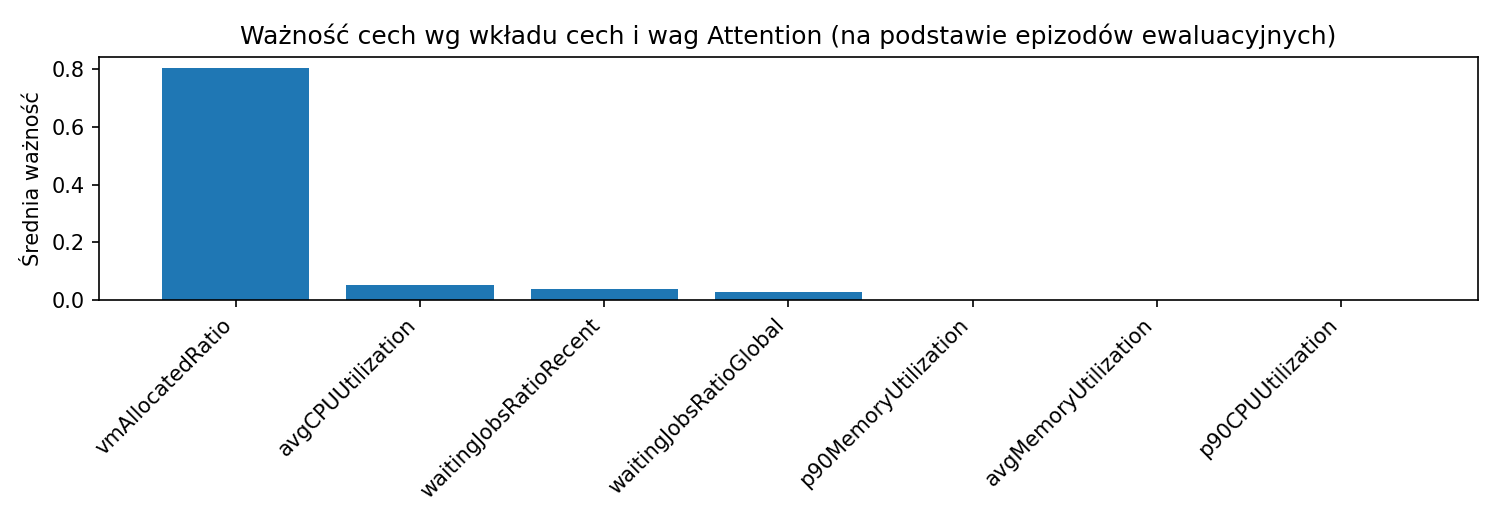

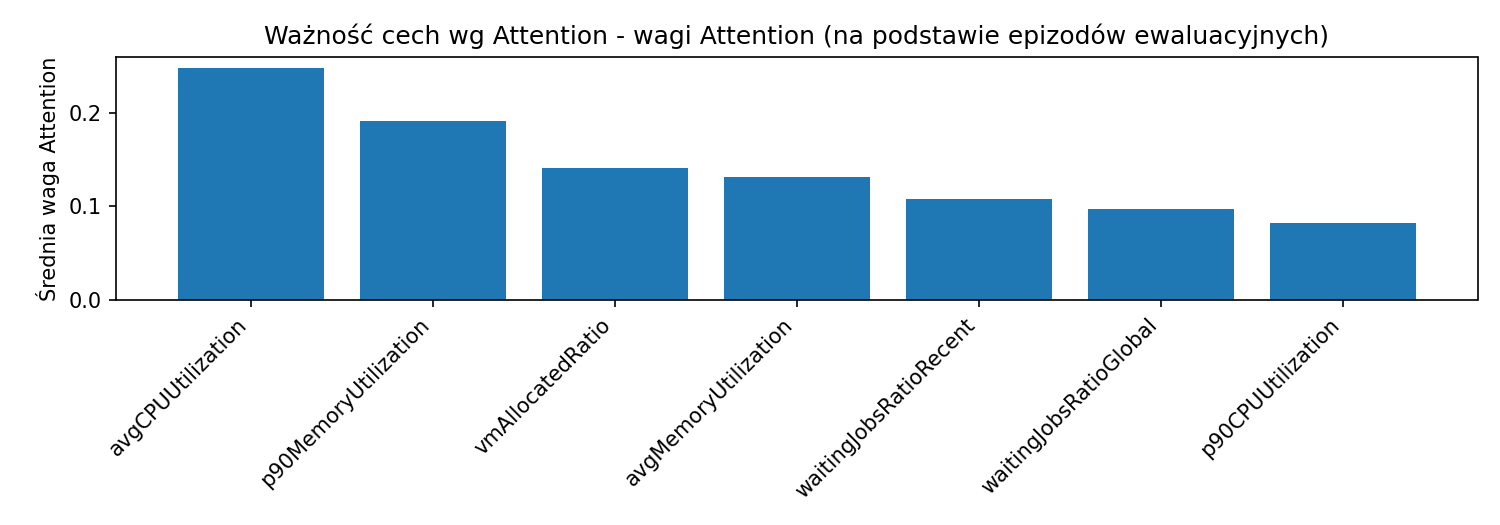

In [14]:
from IPython.display import Image, display

img_path = "./runs/attn_eval_plots/attn_eval_contrib_top7.png"  
display(Image(filename=img_path))
img_path = "./runs/attn_eval_plots/attn_eval_metric_top7.png"
display(Image(filename=img_path))

### SPCA/IG analiza ważności cech na podstawie epizodów ewaluacyjnych

In [ ]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO.load(r'..\FINAL_MODELS\BASELINE\baseline_1\recurrentppo_MlpLstmPolicy_mlplstm_baseline.zip')

### Wersja z rozkladem akcji IG

In [ ]:
# eval_spca_corr_ig.py - SIMPLIFIED, MADE SURE ACTION IS USED FOR IG
import os
from typing import Optional, Sequence, Tuple, Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from spca_selector_backup import SimpleSPCASelector

# ---------------- małe funkcje pomocnicze ----------------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _flatten_obs(obs) -> np.ndarray:
    arr = np.asarray(obs)
    return arr.reshape(-1)  # działa dla (N) oraz (1, N)

def _zscore_cols(X: np.ndarray):
    mu = np.nanmean(X, axis=0, keepdims=True)
    Z = X - mu
    sd = np.nanstd(Z, axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    Z = Z / sd
    return Z, mu.squeeze(0), sd.squeeze(0)

# ---------------- IG dla wartości krytyka V(s) ----------------
def _is_recurrent_policy(policy) -> bool:
    return hasattr(policy, "lstm_actor") and hasattr(policy, "lstm_critic")

@th.no_grad()
def _make_lstm_states(policy, batch: int, device: th.device):
    la, lc = policy.lstm_actor, policy.lstm_critic
    h_a = th.zeros(la.num_layers, batch, la.hidden_size, device=device)
    c_a = th.zeros_like(h_a)
    h_c = th.zeros(lc.num_layers, batch, lc.hidden_size, device=device)
    c_c = th.zeros_like(h_c)
    # Spróbuj użyć oficjalnego kontenera, jeśli jest dostępny
    try:
        from sb3_contrib.common.recurrent.type_aliases import RecurrentStates
        return RecurrentStates(pi=(h_a, c_a), vf=(h_c, c_c))
    except Exception:
        from types import SimpleNamespace
        return SimpleNamespace(pi=(h_a, c_a), vf=(h_c, c_c))

def ig_value_attr(
    model,
    X: np.ndarray,
    baseline: str = "mean",              # wartości: "mean" | "zeros" | "min" | "custom"
    baseline_vec: Optional[np.ndarray] = None,
    m_steps: int = 50,
    batch_size: int = 256,
    device: Optional[str] = None,
    progress: bool = True,
) -> np.ndarray:
    """
    Zastosuj zintegrowane gradienty dla polityki aktora.
    Funkcja celu dla każdego punktu interpolacji to suma log prawdopodobieństw
    deterministycznych akcji polityki w punkcie końcowym (akcje a*).
    Zwraca średnią bezwzględną wartość IG dla każdej cechy w X: [N]
    """
    policy = model.policy
    policy.eval()
    dev = th.device(device or policy.device)
    Xf = th.tensor(X, dtype=th.float32, device=dev)
    R, N = Xf.shape

    if baseline == "zeros":
        b = th.zeros(N, device=dev)
    elif baseline == "mean":
        b = Xf.mean(dim=0)
    elif baseline == "min":
        b = Xf.min(dim=0).values
    elif baseline == "custom":
        assert baseline_vec is not None and baseline_vec.shape == (N,)
        b = th.tensor(baseline_vec, dtype=th.float32, device=dev)
    else:
        raise ValueError("baseline must be 'zeros'|'mean'|'min'|'custom'")

    alphas = th.linspace(1.0 / m_steps, 1.0, m_steps, device=dev)

    IG_abs_sum = th.zeros(N, dtype=th.float32, device=dev)
    total_rows = 0
    recurrent = _is_recurrent_policy(policy)

    if progress:
        print(
            f"[IG(action)] rows={R}, m_steps={m_steps}, batch={batch_size}, "
            f"baseline={baseline}, recurrent={recurrent}"
        )

    def _get_action_dist(obs_t: th.Tensor, lstm_states=None, ep_starts=None):
        if not recurrent:
            try:
                return policy.get_distribution(obs_t)
            except Exception:
                features = policy.extract_features(obs_t)
                latent_pi, _ = policy.mlp_extractor(features)
                return policy._get_action_dist_from_latent(latent_pi)

        features = policy.extract_features(obs_t)
        if lstm_states is None:
            lstm_states = _make_lstm_states(policy, obs_t.shape[0], dev)
        if ep_starts is None:
            ep_starts = th.ones(obs_t.shape[0], dtype=th.float32, device=dev)

        lstm_out_pi, _ = policy._process_sequence(
            features, lstm_states.pi, ep_starts, policy.lstm_actor
        )
        latent_pi, _ = policy.mlp_extractor(lstm_out_pi)
        return policy._get_action_dist_from_latent(latent_pi)

    for start in range(0, R, batch_size):
        end = min(start + batch_size, R)
        xb = Xf[start:end]  # kształt: [B, N]
        B = b.unsqueeze(0).expand_as(xb)
        total_grad = th.zeros_like(xb)

        with th.no_grad():
            if recurrent:
                ep_starts_b = th.ones(xb.shape[0], dtype=th.float32, device=dev)
                lstm_b = _make_lstm_states(policy, xb.shape[0], dev)
                dist_b = _get_action_dist(xb, lstm_states=lstm_b, ep_starts=ep_starts_b)
            else:
                dist_b = _get_action_dist(xb)
            a_star = dist_b.get_actions(deterministic=True)

        for a in alphas:
            x_alpha = (B + a * (xb - B)).clone().detach().requires_grad_(True)
            if recurrent:
                ep_starts = th.ones(x_alpha.shape[0], dtype=th.float32, device=dev)
                lstm_states = _make_lstm_states(policy, x_alpha.shape[0], dev)
                dist_alpha = _get_action_dist(
                    x_alpha, lstm_states=lstm_states, ep_starts=ep_starts
                )
            else:
                dist_alpha = _get_action_dist(x_alpha)

            logp = dist_alpha.log_prob(a_star)
            if logp.dim() > 1:
                logp = logp.view(logp.shape[0], -1).sum(dim=1)
            obj = logp.sum()
            grads = th.autograd.grad(obj, x_alpha, retain_graph=False, create_graph=False)[0]
            total_grad += grads

        ig_batch = (xb - B) * (total_grad / m_steps)  # kształt: [B, N]
        IG_abs_sum += ig_batch.abs().sum(dim=0)
        total_rows += (end - start)
        if progress:
            print(f"  processed {end}/{R}", end="\r")
    if progress:
        print()

    mean_abs_ig = (IG_abs_sum / max(1, total_rows)).detach().cpu().numpy()
    return mean_abs_ig.astype(np.float32)

# ---------------- zbieranie (X, y) podczas epizodów ewaluacyjnych ----------------
@th.no_grad()
def collect_eval_xy(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    target_mode: str = "mc_return",      # wartości: "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
) -> Tuple[np.ndarray, Optional[np.ndarray], Dict[str, Any]]:
    """
    Zbiera pary (X, y) z epizodów ewaluacyjnych.
    X: obserwacje o kształcie [R, N]; y: cele krokowe [R] (lub None, jeśli target_mode == "none").
    """
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    X_rows: List[np.ndarray] = []
    y_rows: List[float] = []
    ep_returns: List[float] = []

    need_values = (target_mode == "gae_return")
    state = None

    def _episode_mc_return(rewards: List[float], gamma: float = 0.99) -> np.ndarray:
        rtg = np.zeros(len(rewards), dtype=np.float32)
        ret = 0.0
        for t in range(len(rewards) - 1, -1, -1):
            ret = float(rewards[t]) + gamma * ret
            rtg[t] = ret
        return rtg

    def _episode_gae_return(rewards: List[float], values: List[float], gamma=0.99, lam=0.95) -> Tuple[np.ndarray, np.ndarray]:
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_gae = 0.0
        for t in range(T - 1, -1, -1):
            next_v = values[t + 1] if t + 1 < T else 0.0
            delta = float(rewards[t]) + gamma * next_v - float(values[t])
            last_gae = float(delta) + gamma * lam * last_gae
            adv[t] = last_gae
        returns = adv + np.asarray(values, dtype=np.float32)
        return returns, adv

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]

        done = False
        episode_obs: List[np.ndarray] = []
        episode_rewards: List[float] = []
        episode_values: List[float] = []

        episode_start = np.array([True], dtype=bool) if is_vec else None

        while not done:
            x_row = _flatten_obs(obs).astype(np.float32)
            episode_obs.append(x_row)

            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(obs, state=state, deterministic=deterministic)

            if need_values:
                try:
                    obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                    v = model.policy.predict_values(obs_t)
                    v = float(np.asarray(v.detach().cpu()).squeeze())
                except Exception:
                    try:
                        obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                        ep_b = th.ones(1, dtype=th.bool, device=obs_t.device)
                        try:
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        except Exception:
                            ep_b = ep_b.float()
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        v = float(np.asarray(out[1].detach().cpu()).squeeze())
                    except Exception:
                        v = 0.0
                episode_values.append(v)

            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done = _done_scalar(d)
                episode_start = d
            else:
                out = env.step(action)
                if len(out) == 5:
                    obs, r, terminated, truncated, info = out
                    done = bool(terminated or truncated)
                else:
                    obs, r, done, info = out
                r_scalar = float(np.asarray(r).squeeze())

            episode_rewards.append(r_scalar)

        ep_returns.append(sum(episode_rewards))

        if target_mode == "mc_return":
            y_rows.extend(list(_episode_mc_return(episode_rewards, gamma=gamma)))
        elif target_mode == "gae_return":
            rets, _ = _episode_gae_return(episode_rewards, episode_values, gamma=gamma, lam=gae_lambda)
            y_rows.extend(list(rets))
        elif target_mode == "none":
            pass
        else:
            raise ValueError("target_mode must be 'mc_return' | 'gae_return' | 'none'")

        X_rows.extend(episode_obs)
        state = None

    X = np.stack(X_rows, axis=0).astype(np.float32)
    y = np.asarray(y_rows, dtype=np.float32) if target_mode != "none" else None
    meta = {"episodes": n_episodes, "steps": X.shape[0], "ep_returns": ep_returns}
    return X, y, meta

# ---------------- główna funkcja: SPCA + IG na ewaluacji ----------------
def spca_corr_ig_on_eval(
    env,
    model,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    n_episodes: int = 10,
    deterministic: bool = True,
    target_mode: str = "mc_return",    # wartości: "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    # Ustawienia SPCA
    spca_components: int = 4,
    spca_alpha: float = 1.0,
    spca_ridge_alpha: float = 0.01,
    spca_method: str = "cd",
    min_nonzero_rate: float = 0.02,
    component_weight: str = "var",
    normalize_spca: bool = True,
    spca_apply_zscore: bool = False,
    # Ustawienia IG
    ig_enable: bool = True,
    ig_baseline: str = "mean",         # wartości: "mean" | "zeros" | "min" | "custom"
    ig_steps: int = 50,
    ig_batch: int = 256,
    ig_sample_size: Optional[int] = None,  # losowo ogranicz liczbę wierszy dla szybkości
    ig_seed: int = 0xC0FFEE,
    # Rysowanie i zapisywanie
    top_k: int = 20,
    save_dir: Optional[str] = None,
    prefix: str = "eval_spca_corr_ig",
    show: bool = False,                # domyślnie bez wyświetlania na ekranie
) -> Dict[str, Any]:
    """
    Uruchamia epizody ewaluacyjne, oblicza wagi SPCA oraz (opcjonalnie) zintegrowane gradienty
    dla wartości krytyka. Zapisuje proste posortowane wykresy słupkowe.
    """
    X, y, meta = collect_eval_xy(
        env, model, n_episodes=n_episodes, deterministic=deterministic,
        target_mode=target_mode, gamma=gamma, gae_lambda=gae_lambda
    )
    N = X.shape[1]
    names = np.array(FEATURE_NAMES if (FEATURE_NAMES is not None and len(FEATURE_NAMES) == N)
                     else [f"f{i}" for i in range(N)], dtype=str)

    # ---- SPCA
    simple_selector = SimpleSPCASelector(
        n_components=spca_components,
        alpha=spca_alpha,
        ridge_alpha=spca_ridge_alpha,
        feature_names=names,
        top_k=top_k,
    )
    X_spca = X
    if spca_apply_zscore:
        X_spca, _, _ = _zscore_cols(X)
    spca_result = simple_selector.compute_from_array(
        X_spca,
        names=names,
        k=top_k,
        plot=False,
    )
    w_spca = spca_result["weights"]
    comps = spca_result["components"]

    # ---- IG (wartość krytyka) na (pod)próbie X
    ig = None
    idx_rows_ig = None
    if ig_enable:
        X_ig = X
        if ig_sample_size is not None and ig_sample_size < X.shape[0]:
            rng = np.random.default_rng(ig_seed)
            idx_rows_ig = rng.choice(X.shape[0], size=ig_sample_size, replace=False)
            X_ig = X[idx_rows_ig]
        ig = ig_value_attr(
            model,
            X_ig,
            baseline=ig_baseline,
            m_steps=ig_steps,
            batch_size=ig_batch,
            device=None,
            progress=True,
        )  # kształt: [N]

    # ---- wypisz ranking Top-K
    k = min(top_k, N)
    print(f"[Eval SPCA/IG] steps={X.shape[0]}, N={N}, episodes={meta['episodes']}, target={target_mode}")
    print(f"Top-{k} by SPCA weight:")
    for rank, j in enumerate(np.argsort(w_spca)[::-1][:k], 1):
        print(f"  {rank:2d}. {names[j]} ({j})  w={w_spca[j]:.6f}")

    if ig is not None:
        print(f"\nTop-{k} by mean |IG| (policy logits):")
        for rank, j in enumerate(np.argsort(ig)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]} ({j})  ig={ig[j]:.6e}")

    # ---- wykresy (zapis, tryb bez ekranu) ----
    def _bar(vals: np.ndarray, title: str, ylabel: str, tag: str):
        idx = np.argsort(vals)[::-1][:k]
        labels = [f"{names[i]} ({i})" for i in idx]
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(range(len(idx)), vals[idx])
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"{prefix}_{tag}_top{k}.png")
            fig.savefig(out, dpi=150)
            print("saved:", out)
        if show:
            plt.show()
        else:
            plt.close(fig)

    _bar(w_spca, f"Top {k} Features by SPCA Weight (eval episodes)", "SPCA weight", "spca")
    if ig is not None:
        _bar(ig, f"Top {k} by mean |IG| (policy logits) (eval episodes)", "mean |IG|", "ig_value")

    # ---- zapisz tablice ----
    saved_paths = {}
    if save_dir:
        np.savez_compressed(
            os.path.join(save_dir, f"{prefix}_summary.npz"),
            X=X, y=(y if y is not None else np.array([], dtype=np.float32)),
            feature_names=names,
            w_spca=w_spca, components=comps,
            ig=(ig if ig is not None else np.array([], dtype=np.float32)),
            ig_idx=(idx_rows_ig if idx_rows_ig is not None else np.array([], dtype=np.int64)),
            meta=np.array([str(meta)], dtype=object),
        )
        saved_paths["npz"] = os.path.join(save_dir, f"{prefix}_summary.npz")

    return {
        "X": X, "y": y, "names": names,
        "w_spca": w_spca, "components": comps,
        "ig": ig,
        "meta": meta,
        "saved": saved_paths,
    }


In [ ]:
# eval_spca_corr_ig.py IMPLEMENTACJA IG Z CAPTUM DLA AKCJI
import os
from typing import Optional, Sequence, Tuple, Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from captum.attr import IntegratedGradients
from spca_selector_backup import SimpleSPCASelector



# ---------------- małe funkcje pomocnicze ----------------
def _scalar(x):
    x = np.asarray(x)
    return float(np.squeeze(x))

def _done_scalar(x):
    x = np.asarray(x).astype(bool)
    x = np.squeeze(x)
    if x.shape == ():
        return bool(x)
    return bool(x.reshape(-1)[0])

def _flatten_obs(obs) -> np.ndarray:
    arr = np.asarray(obs)
    return arr.reshape(-1)  # działa dla (N) oraz (1, N)

def _zscore_cols(X: np.ndarray):
    mu = np.nanmean(X, axis=0, keepdims=True)
    Z = X - mu
    sd = np.nanstd(Z, axis=0, keepdims=True)
    sd[sd == 0] = 1.0
    Z = Z / sd
    return Z, mu.squeeze(0), sd.squeeze(0)

# ---------------- IG dla wartości krytyka V(s) ----------------
def _is_recurrent_policy(policy) -> bool:
    return hasattr(policy, "lstm_actor") and hasattr(policy, "lstm_critic")

@th.no_grad()
def _make_lstm_states(policy, batch: int, device: th.device):
    la, lc = policy.lstm_actor, policy.lstm_critic
    h_a = th.zeros(la.num_layers, batch, la.hidden_size, device=device)
    c_a = th.zeros_like(h_a)
    h_c = th.zeros(lc.num_layers, batch, lc.hidden_size, device=device)
    c_c = th.zeros_like(h_c)
    # Spróbuj użyć oficjalnego kontenera, jeśli jest dostępny
    try:
        from sb3_contrib.common.recurrent.type_aliases import RecurrentStates
        return RecurrentStates(pi=(h_a, c_a), vf=(h_c, c_c))
    except Exception:
        from types import SimpleNamespace
        return SimpleNamespace(pi=(h_a, c_a), vf=(h_c, c_c))

def ig_value_attr(
    model,
    X: np.ndarray,
    baseline: str = "mean",              # wartości: "mean" | "zeros" | "min" | "custom"
    baseline_vec: Optional[np.ndarray] = None,
    m_steps: int = 50,
    batch_size: int = 256,
    device: Optional[str] = None,
    progress: bool = True,
) -> np.ndarray:
    """
    Zastosuj zintegrowane gradienty (Captum) dla polityki aktora.
    Funkcja celu dla każdego punktu interpolacji to suma log prawdopodobieństw
    deterministycznych akcji polityki w punkcie końcowym (akcje a*).
    Zwraca średnią bezwzględną wartość IG dla każdej cechy w X: [N]
    """
    policy = model.policy
    policy.eval()
    dev = th.device(device or policy.device)
    Xf = th.tensor(X, dtype=th.float32, device=dev)
    R, N = Xf.shape

    if baseline == "zeros":
        b = th.zeros(N, device=dev)
    elif baseline == "mean":
        b = Xf.mean(dim=0)
    elif baseline == "min":
        b = Xf.min(dim=0).values
    elif baseline == "custom":
        assert baseline_vec is not None and baseline_vec.shape == (N,)
        b = th.tensor(baseline_vec, dtype=th.float32, device=dev)
    else:
        raise ValueError("baseline must be 'zeros'|'mean'|'min'|'custom'")

    IG_abs_sum = th.zeros(N, dtype=th.float32, device=dev)
    total_rows = 0
    recurrent = _is_recurrent_policy(policy)

    if progress:
        print(
            f"[IG(action)] rows={R}, m_steps={m_steps}, batch={batch_size}, "
            f"baseline={baseline}, recurrent={recurrent}"
        )

    def _get_action_dist(obs_t: th.Tensor, lstm_states=None, ep_starts=None):
        if not recurrent:
            try:
                return policy.get_distribution(obs_t)
            except Exception:
                features = policy.extract_features(obs_t)
                latent_pi, _ = policy.mlp_extractor(features)
                return policy._get_action_dist_from_latent(latent_pi)

        features = policy.extract_features(obs_t)
        if lstm_states is None:
            lstm_states = _make_lstm_states(policy, obs_t.shape[0], dev)
        if ep_starts is None:
            ep_starts = th.ones(obs_t.shape[0], dtype=th.float32, device=dev)

        lstm_out_pi, _ = policy._process_sequence(
            features, lstm_states.pi, ep_starts, policy.lstm_actor
        )
        latent_pi, _ = policy.mlp_extractor(lstm_out_pi)
        return policy._get_action_dist_from_latent(latent_pi)

    for start in range(0, R, batch_size):
        end = min(start + batch_size, R)
        xb_full = Xf[start:end]
        B_full = b.unsqueeze(0).expand_as(xb_full)

        with th.no_grad():
            if recurrent:
                ep_starts_b = th.ones(xb_full.shape[0], dtype=th.float32, device=dev)
                lstm_b = _make_lstm_states(policy, xb_full.shape[0], dev)
                dist_b = _get_action_dist(xb_full, lstm_states=lstm_b, ep_starts=ep_starts_b)
            else:
                dist_b = _get_action_dist(xb_full)
            a_star = dist_b.get_actions(deterministic=True).detach().to(dev)

        def _forward(inputs: th.Tensor) -> th.Tensor:
            if recurrent:
                ep_starts = th.ones(inputs.shape[0], dtype=th.float32, device=dev)
                lstm_states = _make_lstm_states(policy, inputs.shape[0], dev)
                dist = _get_action_dist(inputs, lstm_states=lstm_states, ep_starts=ep_starts)
            else:
                dist = _get_action_dist(inputs)
            logp = dist.log_prob(a_star)
            if logp.dim() > 1:
                logp = logp.view(logp.shape[0], -1).sum(dim=1)
            return logp

        ig = IntegratedGradients(_forward)
        xb = xb_full.clone().detach().requires_grad_(True)
        baselines = B_full.clone().detach()
        attrs = ig.attribute(
            inputs=xb,
            baselines=baselines,
            n_steps=m_steps,
            method="riemann_trapezoid",
        )
        IG_abs_sum += attrs.abs().sum(dim=0)
        total_rows += (end - start)
        if progress:
            print(f"  processed {end}/{R}", end="\r")
    if progress:
        print()

    mean_abs_ig = (IG_abs_sum / max(1, total_rows)).detach().cpu().numpy()
    return mean_abs_ig.astype(np.float32)

# ---------------- zbieranie (X, y) podczas epizodów ewaluacyjnych ----------------
@th.no_grad()
def collect_eval_xy(
    env,
    model,
    n_episodes: int = 10,
    deterministic: bool = True,
    freeze_vecnorm: bool = True,
    target_mode: str = "mc_return",      # wartości: "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
) -> Tuple[np.ndarray, Optional[np.ndarray], Dict[str, Any]]:
    """
    Zbiera pary (X, y) z epizodów ewaluacyjnych.
    X: obserwacje o kształcie [R, N]; y: cele krokowe [R] (lub None, jeśli target_mode == "none").
    """
    if hasattr(env, "norm_reward"):
        env.norm_reward = False
    if freeze_vecnorm and hasattr(env, "training"):
        env.training = False

    is_vec = hasattr(env, "num_envs")
    if is_vec and env.num_envs != 1:
        raise ValueError("Use a single-env VecEnv for eval.")

    X_rows: List[np.ndarray] = []
    y_rows: List[float] = []
    ep_returns: List[float] = []

    need_values = (target_mode == "gae_return")
    state = None

    def _episode_mc_return(rewards: List[float], gamma: float = 0.99) -> np.ndarray:
        rtg = np.zeros(len(rewards), dtype=np.float32)
        ret = 0.0
        for t in range(len(rewards) - 1, -1, -1):
            ret = float(rewards[t]) + gamma * ret
            rtg[t] = ret
        return rtg

    def _episode_gae_return(rewards: List[float], values: List[float], gamma=0.99, lam=0.95) -> Tuple[np.ndarray, np.ndarray]:
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_gae = 0.0
        for t in range(T - 1, -1, -1):
            next_v = values[t + 1] if t + 1 < T else 0.0
            delta = float(rewards[t]) + gamma * next_v - float(values[t])
            last_gae = float(delta) + gamma * lam * last_gae
            adv[t] = last_gae
        returns = adv + np.asarray(values, dtype=np.float32)
        return returns, adv

    for _ in range(n_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]

        done = False
        episode_obs: List[np.ndarray] = []
        episode_rewards: List[float] = []
        episode_values: List[float] = []

        episode_start = np.array([True], dtype=bool) if is_vec else None

        while not done:
            x_row = _flatten_obs(obs).astype(np.float32)
            episode_obs.append(x_row)

            try:
                action, state = model.predict(
                    obs, state=state, episode_start=episode_start,
                    deterministic=deterministic
                )
            except TypeError:
                action, state = model.predict(obs, state=state, deterministic=deterministic)

            if need_values:
                try:
                    obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                    v = model.policy.predict_values(obs_t)
                    v = float(np.asarray(v.detach().cpu()).squeeze())
                except Exception:
                    try:
                        obs_t = th.as_tensor(x_row).to(model.device).float().unsqueeze(0)
                        ep_b = th.ones(1, dtype=th.bool, device=obs_t.device)
                        try:
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        except Exception:
                            ep_b = ep_b.float()
                            out = model.policy.forward(obs_t, state, ep_b, deterministic=True)
                        v = float(np.asarray(out[1].detach().cpu()).squeeze())
                    except Exception:
                        v = 0.0
                episode_values.append(v)

            if is_vec:
                obs, r, d, info = env.step(action)
                r_scalar = _scalar(r)
                done = _done_scalar(d)
                episode_start = d
            else:
                out = env.step(action)
                if len(out) == 5:
                    obs, r, terminated, truncated, info = out
                    done = bool(terminated or truncated)
                else:
                    obs, r, done, info = out
                r_scalar = float(np.asarray(r).squeeze())

            episode_rewards.append(r_scalar)

        ep_returns.append(sum(episode_rewards))

        if target_mode == "mc_return":
            y_rows.extend(list(_episode_mc_return(episode_rewards, gamma=gamma)))
        elif target_mode == "gae_return":
            rets, _ = _episode_gae_return(episode_rewards, episode_values, gamma=gamma, lam=gae_lambda)
            y_rows.extend(list(rets))
        elif target_mode == "none":
            pass
        else:
            raise ValueError("target_mode must be 'mc_return' | 'gae_return' | 'none'")

        X_rows.extend(episode_obs)
        state = None

    X = np.stack(X_rows, axis=0).astype(np.float32)
    y = np.asarray(y_rows, dtype=np.float32) if target_mode != "none" else None
    meta = {"episodes": n_episodes, "steps": X.shape[0], "ep_returns": ep_returns}
    return X, y, meta

# ---------------- główna funkcja: SPCA + IG na ewaluacji ----------------
def spca_corr_ig_on_eval(
    env,
    model,
    FEATURE_NAMES: Optional[Sequence[str]] = None,
    n_episodes: int = 10,
    deterministic: bool = True,
    target_mode: str = "mc_return",    # wartości: "mc_return" | "gae_return" | "none"
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    # Ustawienia SPCA
    spca_components: int = 4,
    spca_alpha: float = 1.0,
    spca_ridge_alpha: float = 0.01,
    spca_method: str = "cd",
    min_nonzero_rate: float = 0.02,
    component_weight: str = "var",
    normalize_spca: bool = True,
    spca_apply_zscore: bool = False,
    # Ustawienia IG
    ig_enable: bool = True,
    ig_baseline: str = "mean",         # wartości: "mean" | "zeros" | "min" | "custom"
    ig_steps: int = 50,
    ig_batch: int = 256,
    ig_sample_size: Optional[int] = None,  # losowo ogranicz liczbę wierszy dla szybkości
    ig_seed: int = 0xC0FFEE,
    # Rysowanie i zapisywanie
    top_k: int = 20,
    save_dir: Optional[str] = None,
    prefix: str = "eval_spca_corr_ig",
    show: bool = False,                # domyślnie bez wyświetlania na ekranie
) -> Dict[str, Any]:
    """
    Uruchamia epizody ewaluacyjne, oblicza wagi SPCA oraz (opcjonalnie) zintegrowane gradienty
    dla wartości krytyka. Zapisuje proste posortowane wykresy słupkowe.
    """
    X, y, meta = collect_eval_xy(
        env, model, n_episodes=n_episodes, deterministic=deterministic,
        target_mode=target_mode, gamma=gamma, gae_lambda=gae_lambda
    )
    N = X.shape[1]
    names = np.array(FEATURE_NAMES if (FEATURE_NAMES is not None and len(FEATURE_NAMES) == N)
                     else [f"f{i}" for i in range(N)], dtype=str)

    # ---- SPCA
    simple_selector = SimpleSPCASelector(
        n_components=spca_components,
        alpha=spca_alpha,
        ridge_alpha=spca_ridge_alpha,
        feature_names=names,
        top_k=top_k,
    )
    X_spca = X
    if spca_apply_zscore:
        X_spca, _, _ = _zscore_cols(X)
    spca_result = simple_selector.compute_from_array(
        X_spca,
        names=names,
        k=top_k,
        plot=False,
    )
    w_spca = spca_result["weights"]
    comps = spca_result["components"]

    # ---- IG (wartość krytyka) na (pod)próbie X
    ig = None
    idx_rows_ig = None
    if ig_enable:
        X_ig = X
        if ig_sample_size is not None and ig_sample_size < X.shape[0]:
            rng = np.random.default_rng(ig_seed)
            idx_rows_ig = rng.choice(X.shape[0], size=ig_sample_size, replace=False)
            X_ig = X[idx_rows_ig]
        ig = ig_value_attr(
            model,
            X_ig,
            baseline=ig_baseline,
            m_steps=ig_steps,
            batch_size=ig_batch,
            device=None,
            progress=True,
        )  # kształt: [N]

    # ---- wypisz ranking Top-K
    k = min(top_k, N)
    print(f"[Eval SPCA/IG] steps={X.shape[0]}, N={N}, episodes={meta['episodes']}, target={target_mode}")
    print(f"Top-{k} by SPCA weight:")
    for rank, j in enumerate(np.argsort(w_spca)[::-1][:k], 1):
        print(f"  {rank:2d}. {names[j]}  w={w_spca[j]:.6f}")

    if ig is not None:
        print(f"\nTop-{k} by mean |IG| (policy logits):")
        for rank, j in enumerate(np.argsort(ig)[::-1][:k], 1):
            print(f"  {rank:2d}. {names[j]}  ig={ig[j]:.6e}")

    # ---- wykresy (zapis, tryb bez ekranu) ----
    def _bar(vals: np.ndarray, title: str, ylabel: str, tag: str):
        idx = np.argsort(vals)[::-1][:k]
        labels = [names[i] for i in idx]
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(range(len(idx)), vals[idx])
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"{prefix}_{tag}_top{k}.png")
            fig.savefig(out, dpi=150)
            print("saved:", out)
        if show:
            plt.show()
        else:
            plt.close(fig)

    _bar(w_spca, f"Top {k} Features by SPCA Weight (eval episodes)", "SPCA weight", "spca")
    if ig is not None:
        _bar(ig, f"Top {k} by mean |IG| (policy logits) (eval episodes)", "mean |IG|", "ig_value")

    # ---- zapisz tablice ----
    saved_paths = {}
    if save_dir:
        np.savez_compressed(
            os.path.join(save_dir, f"{prefix}_summary.npz"),
            X=X, y=(y if y is not None else np.array([], dtype=np.float32)),
            feature_names=names,
            w_spca=w_spca, components=comps,
            ig=(ig if ig is not None else np.array([], dtype=np.float32)),
            ig_idx=(idx_rows_ig if idx_rows_ig is not None else np.array([], dtype=np.int64)),
            meta=np.array([str(meta)], dtype=object),
        )
        saved_paths["npz"] = os.path.join(save_dir, f"{prefix}_summary.npz")

    return {
        "X": X, "y": y, "names": names,
        "w_spca": w_spca, "components": comps,
        "ig": ig,
        "meta": meta,
        "saved": saved_paths,
    }


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive,
c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive,
c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive,
c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

[IG(action)] rows=250, m_steps=50, batch=256, baseline=mean, recurrent=True
  processed 250/250
[Eval SPCA/IG] steps=250, N=7, episodes=10, target=mc_return
Top-7 by SPCA weight:
   1. waitingJobsRatioGlobal (5)  w=0.289809
   2. vmAllocatedRatio (0)  w=0.267059
   3. avgCPUUtilization (1)  w=0.240776
   4. waitingJobsRatioRecent (6)  w=0.202355
   5. p90MemoryUtilization (4)  w=0.000000
   6. avgMemoryUtilization (3)  w=0.000000
   7. p90CPUUtilization (2)  w=0.000000

Top-7 by mean |IG| (policy logits):
   1. vmAllocatedRatio (0)  ig=1.074318e-02
   2. avgCPUUtilization (1)  ig=4.781537e-03
   3. waitingJobsRatioGlobal (5)  ig=4.245877e-03
   4. waitingJobsRatioRecent (6)  ig=1.005618e-04
   5. p90MemoryUtilization (4)  ig=0.000000e+00
   6. avgMemoryUtilization (3)  ig=0.000000e+00
   7. p90CPUUtilization (2)  ig=0.000000e+00
saved: logs/eval\eval_spca_ig_spca_top7.png


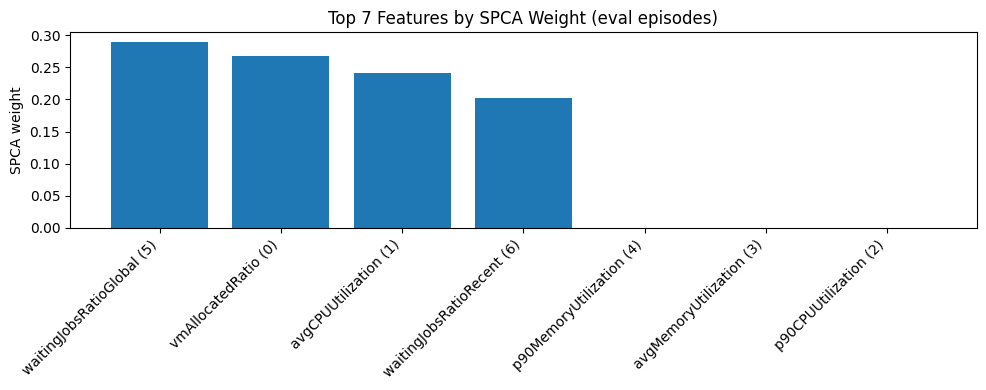

saved: logs/eval\eval_spca_ig_ig_value_top7.png


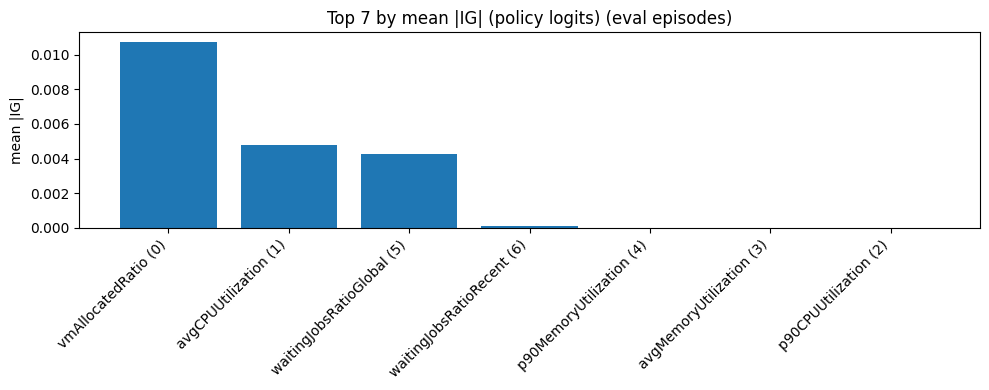

In [ ]:

from utils import FEATURE_NAMES  # your names list

result = spca_corr_ig_on_eval(
    env=env,
    model=model,
    FEATURE_NAMES=FEATURE_NAMES,      # optional list length = obs dim
    n_episodes=10,
    deterministic=True,
    target_mode="mc_return",
    spca_components=3,
    spca_alpha=1.0,
    spca_ridge_alpha=0.01,
    component_weight="var",
    normalize_spca=True,
    spca_apply_zscore=True,          # <-- new: set True to z-score X before SPCA
    ig_enable=True,
    ig_baseline="mean",
    ig_steps=50,
    ig_batch=256,
    ig_sample_size=None,
    top_k=20,
    save_dir="logs/eval",
    prefix="eval_spca_ig",
    show=True,
)


In [1]:
from pathlib import Path
from IPython.display import display, Image

folder = Path("attention_analysis/runs/eval_spca_corr_ig")  

for png in sorted(folder.glob("*.png")):
    print(png.name)
    display(Image(filename=str(png)))